# IMDB Sentiment analysis

*This tutorial is based on [An Introduction to Keras Preprocessing Layers](https://blog.tensorflow.org/2021/11/an-introduction-to-keras-preprocessing.html) by Matthew Watson and [Text classification with TensorFlow Hub: Movie reviews](https://www.tensorflow.org/tutorials/keras/text_classification_with_hub) by TensorFlow.*
 
- Goal: build a binary sentiment classification model with keras preprocessing
- Data: imdb movie review dataset. 

## Setup

In [44]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import layers

print("Version: ", tf.__version__)

Version:  2.7.1


## Data

- Dataset with 50,000 polar movie reviews (positive or negative)
- Training data and test data each 25,000 
- Training and testing sets are balanced (contain an equal number of positive and negative reviews)
- The input data consists of sentences (strings)
- The labels to predict are either 0 or 1.

### Data import

- Import data as batches with size 32
- We use 3 data splits: training, validation and test data
- Split the data into 60% training and 40% test
- Split training into 60% training and 40% validation
- Resulting data split:
  - 15,000 examples for training, 
  - 10,000 examples for validation
  - 25,000 examples for testing.

In [55]:
train_ds, val_ds, test_ds = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

In [1]:
#import tensorflow as tf
#import tensorflow_datasets as tfds

#train_ds = tfds.load('imdb_reviews', split='train', as_supervised=True).batch(32)

2022-04-06 21:26:24.070488: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 100%|██████████| 1/1 [00:21<00:00, 21.86s/ url]
2022-04-06 21:27:44.856372: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Dataset imdb_reviews downloaded and prepared to /Users/jankirenz/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


## Explore data

- Each example is a sentence representing the movie review and a corresponding label. 
- The sentence is not preprocessed in any way. 
- The label is an integer value of either 0 or 1
  - 0 is a negative review
  - 1 is a positive review.
- Let's print first 2 examples.

In [76]:
for x, y in train_ds.take(2): 
    print("Input:", x) 
    print(50*".")     
    print("Target:", y) 
    print(50*"-")  

Input: tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
..................................................
Target: tf.Tensor(0, shape=(), dtype=int64)
--------------------------------------------------
Input: tf.Tensor(b'I have been known to fall asleep during films, but this is usually due to a comb

## Data preprocessing

- How to represent the text?

- Option 1: One-hot encoding 
  - Example: a color feature gets a 1 in a specific index for different colors ('red' = [0, 0, 1, 0, 0])

 - Option 2: embed the feature 
   - Example: each color maps to a unique trainable vector ('red' = [0.1, 0.2, 0.5, -0.2]

- Larger category spaces: might do better with an embedding
- Smaller spaces: one-hot encoding

### TextVectorization

- We will be working with raw text (natural language inputs)
- so we will use the [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer.
- It transforms a batch of strings (one example = one string) into either a
  - list of token indices (one example = 1D tensor of integer token indices) or 
  - dense representation (one example = 1D tensor of float values representing data about the example's tokens). 

- [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) steps:

1. Standardize each example (usually lowercasing + punctuation stripping)
1. Split each example into substrings (usually words)
1. Recombine substrings into tokens (usually ngrams)
1. Index tokens (associate a unique int value with each token)
1. Transform each example using this index, either into a vector of ints or a dense float vector.

#### Multi-hot encoding

- Multi-hot encoding: only consider the presence or absence of terms in the review.

- For example: 
    - layer vocabulary is ['movie', 'good', 'bad']
    - a review read 'This movie was bad.'
    - We would encode this as [1, 0, 1]
    - where movie (the first vocab term) and bad (the last vocab term) are present.

1. Create a `TextVectorization` layer with multi-hot output and a max of 2500 tokens
1. Map over our training dataset and discard the integer label indicating a positive or negative review (this gives us a dataset containing only the review text) 
1. `adapt()` the layer over this dataset, which causes the layer to learn a vocabulary of the most frequent terms in all documents, capped at a max of 2500.

In [47]:
text_vectorizer = layers.TextVectorization(
     output_mode='multi_hot', 
     max_tokens=2500
     )

features = train_ds.map(lambda x, y: x)

text_vectorizer.adapt(features)

- `Adapt` is a utility function on all stateful preprocessing layers, which allows layers to set their internal state from input data. 

- Calling adapt is always optional. 
- For TextVectorization, we could instead supply a precomputed vocabulary on layer construction, and skip the adapt step.

- We will define two functions: 

1. `preprocess`, which converts raw input data to the representation we want for our model, and 
1. `forward_pass`, which applies the trainable layers.

In [49]:
def preprocess(x):
  return text_vectorizer(x)

def forward_pass(x):
  return layers.Dense(1)(x) 


## Model

### Architecture

- We can now train a simple linear model on top of this multi-hot encoding. 


In [68]:
inputs = keras.Input(shape=(1,), dtype='string')

outputs = layers.Dense(1)(text_vectorizer(inputs))

model = keras.Model(inputs, outputs)


### Compile

In [72]:
model.compile(
    optimizer='adam',
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
    )

- Show model summary

In [80]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 2500)             0         
 ectorization)                                                   
                                                                 
 dense_7 (Dense)             (None, 1)                 2501      
                                                                 
Total params: 2,501
Trainable params: 2,501
Non-trainable params: 0
_________________________________________________________________


### Training

- Train the model for 5 epochs in mini-batches of 512 samples
- This is 5 iterations over all samples in the x-train and y-train tensors 
- We shuffle the data and use a buffer_size of 10000 to fill our batches
- While training, monitor the model's loss and accuracy on the 10,000 samples from the validation set:


*`buffer_size` is the number of items in the shuffle buffer. The function fills the buffer and then randomly samples from it. A big enough buffer is needed for proper shuffling, but it's a balance with memory consumption. Reshuffling happens automatically at every epoch*

In [79]:
history = model.fit(train_ds.shuffle(buffer_size=10000).batch(512),
                    epochs=5,
                    validation_data=val_ds.batch(512),
                    verbose=1)

Epoch 1/5
30/30 [==============================] - 1s 32ms/step - loss: 0.3583 - accuracy: 0.8477 - val_loss: 0.3784 - val_accuracy: 0.8400
Epoch 2/5
30/30 [==============================] - 1s 32ms/step - loss: 0.3486 - accuracy: 0.8560 - val_loss: 0.3709 - val_accuracy: 0.8414
Epoch 3/5
30/30 [==============================] - 1s 32ms/step - loss: 0.3398 - accuracy: 0.8614 - val_loss: 0.3643 - val_accuracy: 0.8403
Epoch 4/5
30/30 [==============================] - 1s 33ms/step - loss: 0.3320 - accuracy: 0.8657 - val_loss: 0.3588 - val_accuracy: 0.8411
Epoch 5/5
30/30 [==============================] - 1s 32ms/step - loss: 0.3250 - accuracy: 0.8665 - val_loss: 0.3537 - val_accuracy: 0.8463


#### Inspect layers

- Let’s visualize the topology of the model

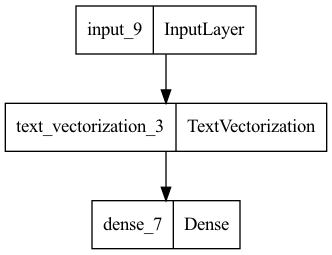

In [81]:
keras.utils.plot_model(model, "sentiment_classifier.png")

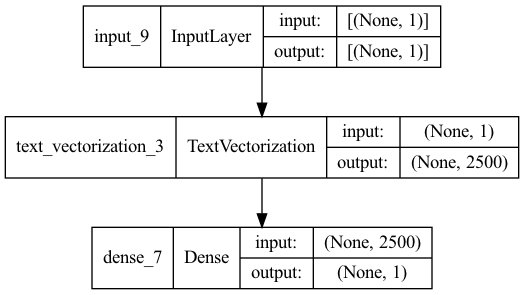

In [82]:
keras.utils.plot_model(model, "sentiment_classifier_with_shape_info.png", show_shapes=True)

## Evaluation

That’s it for an end-to-end training example, and already enough for 85% accuracy. You can find complete code for this example at the bottom of this post.

Let’s experiment with a new feature. Our multi-hot encoding does not contain any notion of review length, so we can try adding a feature for normalized string length. Preprocessing layers can be mixed with TensorFlow ops and custom layers as desired. Here we can combine the tf.strings.length function with the Normalization layer, which will scale the input to have 0 mean and 1 variance. We have only updated code up to the preprocess function below, but we will show the rest of training for clarity.

## Model

**Displaying the model's summary**

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 2500)             0         
 torization)                                                     
                                                                 
 dense (Dense)               (None, 1)                 2501      
                                                                 
Total params: 2,501
Trainable params: 2,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# This layer will scale our review length feature to mean 0 variance 1.
normalizer = tf.keras.layers.Normalization(axis=None)
normalizer.adapt(features.map(lambda x: tf.strings.length(x)))

def preprocess(x):
  multi_hot_terms = text_vectorizer(x)
  normalized_length = normalizer(tf.strings.length(x))
  # Combine the multi-hot encoding with review length.
  return tf.keras.layers.concatenate((multi_hot_terms, normalized_length))

def forward_pass(x):
  return tf.keras.layers.Dense(1)(x)  # Linear model.

inputs = tf.keras.Input(shape=(1,), dtype='string')
outputs = forward_pass(preprocess(inputs))
model = tf.keras.Model(inputs, outputs)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))
model.fit(train_ds, epochs=5)


Above, we create the normalization layer and adapt it to our input. Within the preprocess function, we simply concatenate our multi-hot encoding and length features together. We learn a linear model over the union of the two feature representations.

The last change we can make is to speed up training. We have one major opportunity to improve our training throughput. Right now, every training step, we spend some time on the CPU performing string operations (which cannot run on an accelerator), followed by calculating a loss function and gradients on a GPU.

This gap in accelerator usage is totally unnecessary! Preprocessing is distinct from the actual forward pass of our model. The preprocessing doesn't use any of the parameters being trained. It’s a static transformation that we could precompute.

To speed things up, we would like to prefetch our preprocessed batches, so that each time we are training on one batch we are preprocessing the next. This is easy to do with the tf.data library, which was built for uses like this. The only major change we need to make is to split our monolithic keras.Model into two: one for preprocessing and one for training. This is easy with Keras’ functional API.

In [ ]:
inputs = tf.keras.Input(shape=(1,), dtype="string")
preprocessed_inputs = preprocess(inputs)
outputs = forward_pass(preprocessed_inputs)

# The first model will only apply preprocessing.
preprocessing_model = tf.keras.Model(inputs, preprocessed_inputs)
# The second model will only apply the forward pass.
training_model = tf.keras.Model(preprocessed_inputs, outputs)
training_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))

# Apply preprocessing asynchronously with tf.data.
# It is important to call prefetch and remember the AUTOTUNE options.
preprocessed_ds = train_ds.map(
    lambda x, y: (preprocessing_model(x), y),
    num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# Now the GPU can focus on the training part of the model.
training_model.fit(preprocessed_ds, epochs=5)


n the above example, we pass a single keras.Input through our preprocess and forward_pass functions, but define two separate models over the transformed inputs. This slices our single graph of operations into two. Another valid option would be to only make a training model, and call the preprocess function directly when we map over our dataset. In this case, the keras.Input would need to reflect the type and shape of the preprocessed features rather than the raw strings.

Using tf.data to prefetch batches cuts our train step time by over 30%! Our compute time now looks more like the following:

We could even go a step further than this, and use tf.data to cache our preprocessed dataset in memory or on disk. We would simply add a .cache() call directly before the call to prefetch. In this way, we could entirely skip computing our preprocessing batches after the first epoch of training.

After training, we can rejoin our split model into a single model during inference. This allows us to save a model that can directly handle raw input data.



In [ ]:
inputs = preprocessing_model.input
outputs = training_model(preprocessing_model(inputs))
inference_model = tf.keras.Model(inputs, outputs)
inference_model.predict(
    tf.constant(["Terrible, no good, trash.", "I loved this movie!"]))


Keras preprocessing layers aim to provide a flexible and expressive way to build data preprocessing pipelines. Prebuilt layers can be mixed and matched with custom layers and other tensorflow functions. Preprocessing can be split from training and applied efficiently with tf.data, and joined later for inference. We hope they allow for more natural and efficient iterations on feature representation in your models.

To play around with the code from this post in a Colab, you can follow this link. To see a wide range of tasks you can do with preprocessing layers, see the Quick Recipes section of our preprocessing guide. You can also check out our complete tutorials for basic text classification, image data augmentation, and structured data classification.



## Evaluation